This implementation contains a class that has a svm from scratch. This svm is used in subsets of cifar 10 dataset and furthermore in 2 classes of it for binary classification. The performance of the machine is examined with linear or polynomial kernel and different values in the other parameters. Also, the code prints correct and incorrect examples of classification, the accuracy in training and testing data and then the confusion matrix of them, the decision boundary and the support vectors.
The code is written

In [21]:
import numpy as np
from keras.datasets import cifar10

# load the cifar 10 dataset, select 2 classes and convert to binary format.
# the first class (specified by class_indices[0]) is assigned the label 0, and the second class is assigned the label 1.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_indices = [0, 1]

train_mask = np.isin(y_train, class_indices).squeeze()
x_train_binary = x_train[train_mask]
y_train_binary = y_train[train_mask]

test_mask = np.isin(y_test, class_indices).squeeze()
x_test_binary = x_test[test_mask]
y_test_binary = y_test[test_mask]

y_train_binary = np.where(y_train_binary == class_indices[0], 0, 1)
y_test_binary = np.where(y_test_binary == class_indices[0], 0, 1)

x_train_binary = x_train_binary.astype('float32') / 255.0
x_test_binary = x_test_binary.astype('float32') / 255.0

print("Shapes after filtering:")
print("Training set:", x_train_binary.shape, y_train_binary.shape)
print("Test set:", x_test_binary.shape, y_test_binary.shape)


Shapes after filtering:
Training set: (10000, 32, 32, 3) (10000, 1)
Test set: (2000, 32, 32, 3) (2000, 1)


In [22]:
class SVM():
    def __init__(self):
        self.kernels = {
            'linear': self.kernel_linear,
            'polynomial': self.kernel_polynomial
        }
        self.max_iter = None # parameter to define the number of maximum iterations
        self.kernel_type = None # parameter to define the kind of kernel we have
        self.C = None # parameter of reguralization
        self.epsilon = None # threshold
        self.degree = None  # parameter for the degree of polynomial
        self.support_vectors = None
        self.w = None # weights
        self.b = None  #bias


    def set_params(self, max_iter=None, kernel_type=None, C=None, epsilon=None, degree=None):
        if max_iter is not None:
            self.max_iter = max_iter
        if kernel_type is not None:
            self.kernel_type = kernel_type
        if C is not None:
            self.C = C
        if epsilon is not None:
            self.epsilon = epsilon
        if degree is not None:
            self.degree = degree

    # computes the linear kernel between two vectors
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)

    #  function computes the polynomial kernel
    def kernel_polynomial(self, x1, x2):
        if self.degree is None:
            raise ValueError("Polynomial degree not set. Use set_params() to set the degree.")
        return np.power(np.dot(x1, x2.T), self.degree)

    #  calculates the bias term 'b'
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)

    # calculates the weight vector 'w'
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha, y))

    # calculates the decision function using the sign of the dot product of 'w' and input data X, plus the bias 'b'
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)

    # computes the error for a given example
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b)[0] - y_k.item()

    #  calculates the decision boundary
    def decision_boundary(self):
        if self.w is None or self.b is None:
            raise ValueError("Model not trained. Call fit() method first.")
        return -self.b / self.w[0]  # if w is 1d array

    # computes the values of L and H
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if y_i != y_j:
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))

    def get_rnd_int(self, a, b, z):
        i = z
        cnt = 0
        while i == z and cnt < 1000:
            i = np.random.randint(a, b)
            cnt = cnt + 1
        return i

    def decision_function(self, X):
        return np.dot(self.w.T, X.T) + self.b

    def predict(self, X):
        decision_values = self.decision_function(X)
        return np.squeeze(np.sign(decision_values).astype(int))

    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        correct_classifications = 0
        incorrect_classifications = 0
        correct_examples = []
        incorrect_examples = []

        total_examples = 0
        while count < self.max_iter:
            count += 1
            alpha_prev = np.copy(alpha)

            if count == 1:
                alpha_idx = np.where((alpha > 0) & (alpha < self.C))[0]
                self.support_vectors = X[alpha_idx, :]

            for j in range(0, n):
                i = self.get_rnd_int(0, n - 1, j)
                x_i, x_j, y_i, y_j = X[i, :], X[j, :], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
             #   k_ij = np.power(k_ij + 1, self.degree) --- used in polynomial kernel


                if k_ij == 0:
                    continue

                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                alpha[j] = alpha_prime_j + (y_j * (E_i - E_j)) / k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)
                alpha[i] = alpha_prime_i + y_i * y_j * (alpha_prime_j - alpha[j])

                alpha_idx = np.where((alpha > 0) & (alpha < self.C))[0]
                self.support_vectors = X[alpha_idx, :]

                prediction_i = self.predict(x_i.reshape(1, -1))[0]
                prediction_j = self.predict(x_j.reshape(1, -1))[0]

                if (y_i == 1 and prediction_i == 1) or (y_i == -1 and prediction_i == -1):
                    correct_examples.append((x_i, y_i, prediction_i))
                    correct_classifications += 1
                    total_examples += 1
                else:
                    incorrect_examples.append((x_i, y_i, prediction_i))
                    incorrect_classifications += 1
                    total_examples += 1

                if (y_j == 1 and prediction_j == 1) or (y_j == -1 and prediction_j == -1):
                    correct_examples.append((x_j, y_j, prediction_j))
                    correct_classifications += 1
                    total_examples += 1
                else:
                    incorrect_examples.append((x_j, y_j, prediction_j))
                    incorrect_classifications += 1
                    total_examples += 1

            # Check convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count % 5 == 1:
                # Print results every 5 iterations
                print("Iteration:", count, "\nDifference:", f"{diff:.2%}")
                print("Correct Classifications:", correct_classifications)
                print("Incorrect Classifications:", incorrect_classifications)

                # Calculate and print rates
                if total_examples > 0:
                    correct_rate = correct_classifications / total_examples
                    incorrect_rate = incorrect_classifications / total_examples
                    print("Correct Rate: {:.2%}".format(correct_rate))
                    print("Incorrect Rate: {:.2%}".format(incorrect_rate))
                    print('\n')

        # after the iterations
        if count >= self.max_iter:
            print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
        else:
            print("Training finished after {} iterations".format(count))

        print("Final Correct Classifications:", correct_classifications)
        print("Final Total Examples:", total_examples)

        total_examples = correct_classifications + incorrect_classifications
        if total_examples > 0:
            accuracy = correct_classifications / total_examples
            print("Final Accuracy:", f"{accuracy:.2%}")
            print("\nFinal Correct Examples:")
            for example in correct_examples[:min(3, len(correct_examples))]:
                print(f"Input: {example[0]}, True Label: {example[1]}, Predicted Label: {example[2]}")

            print("\nFinal Incorrect Examples:")
            for example in incorrect_examples[:min(3, len(incorrect_examples))]:
                print(f"Input: {example[0]}, True Label: {example[1]}, Predicted Label: {example[2]}")

        self.b = self.calc_b(X, y, self.w)
        self.w = self.calc_w(alpha, y, X)

        return self.support_vectors, alpha

In [23]:
import time
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

training_subset_size = 500
test_subset_size = 100

x_train_subset = x_train_binary[:training_subset_size]
y_train_subset = y_train_binary[:training_subset_size]

x_test_subset = x_test_binary[:test_subset_size]
y_test_subset = y_test_binary[:test_subset_size]

x_train_flattened = x_train_subset.reshape(x_train_subset.shape[0], -1)
x_test_flattened = x_test_subset.reshape(x_test_subset.shape[0], -1)

print(x_train_flattened.shape)
print(y_train_subset.shape)
print(x_test_flattened.shape)
print(y_test_subset.shape)

model = SVM()
model.set_params(max_iter=100, kernel_type='linear', C=1.0, epsilon=0.001)
# model.set_params(max_iter=100, kernel_type='polynomial', C=0.5, epsilon=0.001, degree=1)
start_time = time.time()

model.fit(x_train_flattened, y_train_subset)

training_time = time.time() - start_time
print("Training Time: {:.2f} seconds".format(training_time))

train_predictions = model.predict(x_train_flattened)


(500, 3072)
(500, 1)
(100, 3072)
(100, 1)
Iteration: 1 
Difference: 3.71%
Correct Classifications: 490
Incorrect Classifications: 510
Correct Rate: 49.00%
Incorrect Rate: 51.00%


Iteration: 6 
Difference: 3.43%
Correct Classifications: 2918
Incorrect Classifications: 3082
Correct Rate: 48.63%
Incorrect Rate: 51.37%


Iteration: 11 
Difference: 3.82%
Correct Classifications: 5323
Incorrect Classifications: 5677
Correct Rate: 48.39%
Incorrect Rate: 51.61%


Iteration: 16 
Difference: 3.50%
Correct Classifications: 7737
Incorrect Classifications: 8263
Correct Rate: 48.36%
Incorrect Rate: 51.64%


Iteration: 21 
Difference: 3.31%
Correct Classifications: 10169
Incorrect Classifications: 10831
Correct Rate: 48.42%
Incorrect Rate: 51.58%


Iteration: 26 
Difference: 3.55%
Correct Classifications: 12588
Incorrect Classifications: 13412
Correct Rate: 48.42%
Incorrect Rate: 51.58%


Iteration: 31 
Difference: 3.51%
Correct Classifications: 15047
Incorrect Classifications: 15953
Correct Rate: 4

In [24]:
boundary = model.decision_boundary()
print("Decision Boundary:", boundary)


Decision Boundary: [6.65357863e+02 8.27135833e+02            inf            inf
 9.55528025e+02            inf 6.52759993e+02 7.70627299e+02
 8.26627942e+02            inf 7.09259432e+02 5.53641596e+02
 7.06000756e+02 6.87253495e+02 5.60031632e+02            inf
 8.47360797e+02            inf 4.86184405e+02 7.86557905e+02
 6.35068697e+02 1.20521577e+03 8.11967999e+02 4.75986347e+02
            inf            inf 5.87566275e+02 5.97779442e+02
            inf 1.70073930e+02 6.18563266e+02 4.68579875e+02
 5.68489807e+02 6.70172029e+02            inf 7.93176661e+02
 5.99561957e+02            inf 6.67842536e+02            inf
            inf            inf 8.82442595e+02 6.54567640e+02
 8.41567727e+02            inf            inf            inf
 9.17146150e+02 4.98540954e+02            inf 5.34771532e+02
 5.38773834e+02 3.73858961e+02 5.68876850e+02 6.93979603e+02
 1.01746987e+03 5.19734281e+02            inf 8.33238279e+02
            inf            inf 6.33870428e+02            inf
     

<ipython-input-22-f9a8511a7110>:60: RuntimeWarning: divide by zero encountered in divide
  return -self.b / self.w[0]  # if w is 1d array


In [25]:
support_vectors = model.support_vectors

print("Number of Support Vectors:", support_vectors.shape[0])
print("Indices of Support Vectors:", np.where(np.isin(x_train_flattened, support_vectors).all(axis=1))[0])

Number of Support Vectors: 245
Indices of Support Vectors: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 

In [26]:
predictions = model.predict(x_test_flattened)

print("Predictions:", predictions)
print(predictions.shape)

Predictions: [[ 1  1  1 ...  1  1  1]
 [ 1 -1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [ 1  1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]
(500, 100)


In [27]:
predicted_labels = np.where(predictions == 1, class_indices[0], class_indices[1])
print("Predicted Labels:", predicted_labels)

Predicted Labels: [[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


Testing Accuracy: 41.00%


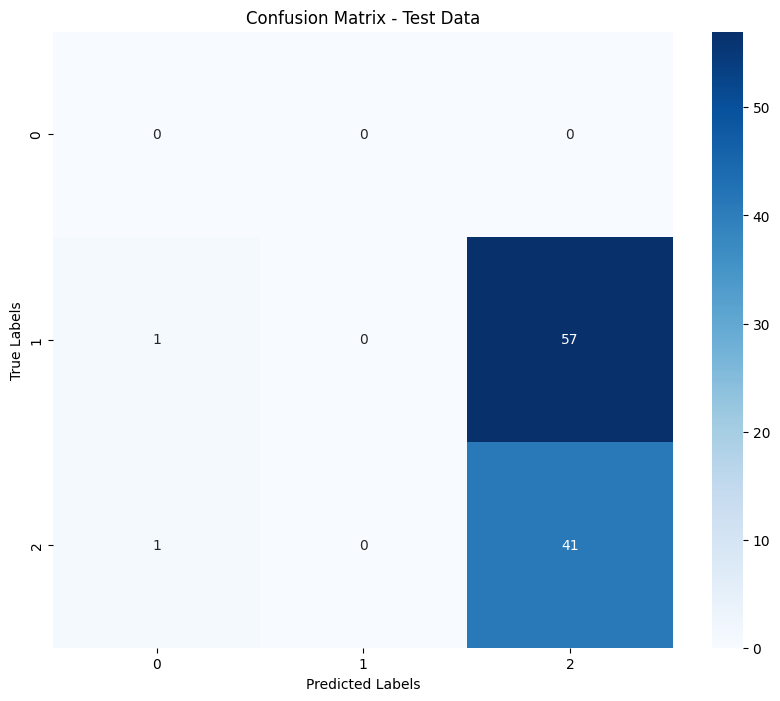

Training Accuracy: 48.00%


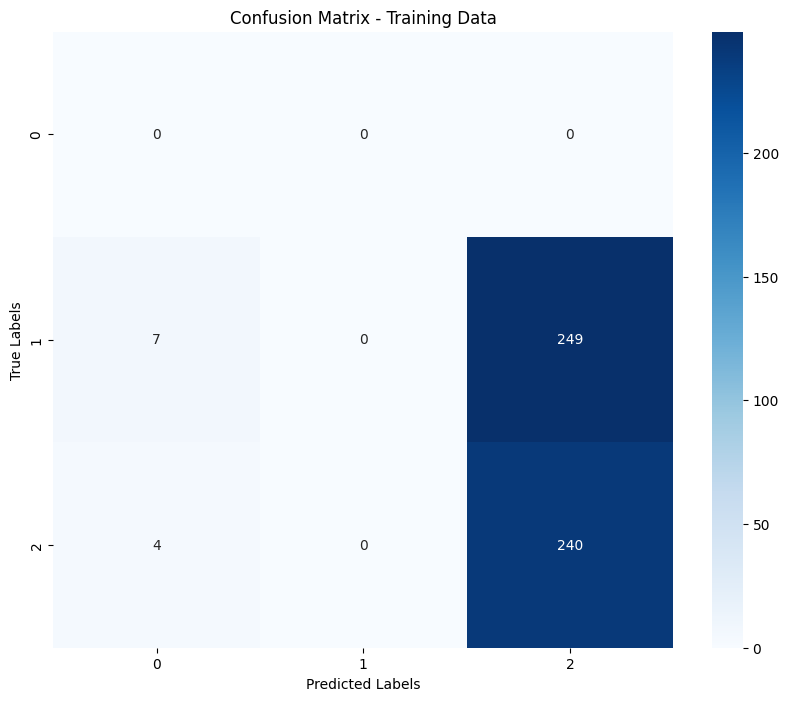

Unique labels in Y_train_subset: [0 1]
Unique labels in y_pred_train: [-1  1]
Unique labels in Y_test_subset: [0 1]
Unique labels in y_pred_test: [-1  1]


In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_train = [model.predict(x.reshape(1, -1))[0] for x in x_train_flattened]

y_pred_test = [model.predict(x.reshape(1, -1))[0] for x in x_test_flattened]

accuracy_test = accuracy_score(y_test_subset, y_pred_test)

print("Testing Accuracy:", f"{accuracy_test:.2%}")

cm_test = confusion_matrix(y_test_subset, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

accuracy_train = accuracy_score(y_train_subset, y_pred_train)
print("Training Accuracy:", f"{accuracy_train:.2%}")

cm_train = confusion_matrix(y_train_subset, y_pred_train)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

print("Unique labels in Y_train_subset:", np.unique(y_train_subset))
print("Unique labels in y_pred_train:", np.unique(y_pred_train))

print("Unique labels in Y_test_subset:", np.unique(y_test_subset))
print("Unique labels in y_pred_test:", np.unique(y_pred_test))
